#### Decision Tree 의 Parameter 
- min_samples_split : 노드 분할을 위한 최소 샘플데이터 수. 이 숫자보다 작으면 더이상 노드를 추가하지 않는다. 이 값이 클수록 노드 분할을 많이 하지 못한다. 
- min_samples_leaf : 리프노드(결정노드)가 되기 위한 최소 샘플 데이터 수, 이 숫자보다 작으면 리프가 될 수 없다. 즉, 이 값이 클수록 함부로 분할할 수 없게 된다. 
- max_features : 최대 피쳐개수. 즉, 규칙노드에서 데이터셋이 가지고 있는 피쳐중, 정해진 개수만큼만 사용
- max_depth : 최대 깊이 
- max_leaf_nodes : 최대 리프노드 개수 

In [12]:
# 데이터셋 준비
import pandas as pd
import numpy as np 
from sklearn.datasets import load_iris, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 분류문제 데이터 
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['label']=iris.target
iris_data = iris_df.drop(columns=['label'])

scaler = StandardScaler()
scaler.fit(iris_data)
iris_scaled = scaler.transform(iris_data)
iris_df_scaled = pd.DataFrame(data=iris_scaled, columns=iris.feature_names)
iris_label = iris_df['label']

x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(iris_df_scaled, iris_label,
                                                   test_size = 0.2, random_state=11)

# 회귀문제 데이터
data = load_diabetes()
X = data.data
y = data.target

# 2. 훈련 데이터와 테스트 데이터 분할
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Decision Tree - Classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

dt_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_clf.fit(x_train_clf, y_train_clf)
y_pred_clf = dt_clf.predict(x_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)
print(f"모델 정확도: {accuracy:.4f}")

모델 정확도: 0.9333


In [14]:
# Decision Tree - Regression
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
dt_reg.fit(x_train_reg, y_train_reg)
y_pred_reg = dt_reg.predict(x_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"모델 MSE: {mse:.4f}")

모델 MSE: 3568.9653


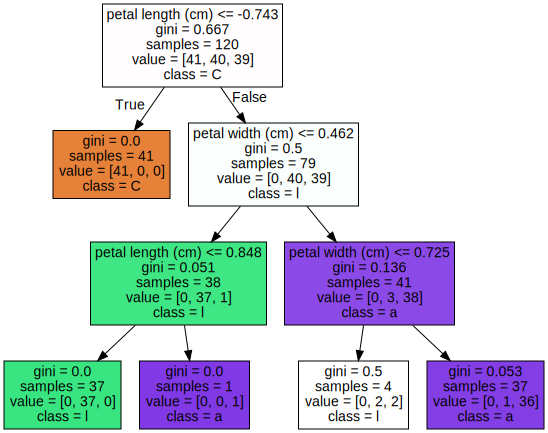

In [15]:
# Decision Tree 시각화. 
# Graphviz 를 통합 시각화
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names='Class', feature_names = iris.feature_names,
                 impurity=True, filled=True)

import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [16]:
# Decision Tree 의 피쳐 중요도 확인

print("Feature importances:{0}".format(np.round(dt_clf.feature_importances_,3)))

Feature importances:[0.    0.    0.558 0.442]


#### Ensemble (앙상블)
- 여러 개의 개별 머신러닝 모델을 조합하여 더 강력한 모델을 만드는 기법이다.
- 결합 방법에 따라 보팅(Voting), 배깅(Bagging), 부스팅(Boosting), 스태킹(Stacking) 4가지로 나뉨

1. 보팅(Voting)
- "같은 데이터셋"에 대해서 여러 다른 종류의 모델로 학습하고 예측한 결과를 통해 최종 투표하는 방식
- Hard = 다수결의 원칙 / Soft = Class별 확률의 평균으로 결정한다. 일반적으로는 Soft Voting 을 주로 사용

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#개별 모델 생성
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

#개별 모델 학습 및 평가 
lr_clf.fit(x_train_clf,y_train_clf)
knn_clf.fit(x_train_clf,y_train_clf)
pred_lr = lr_clf.predict(x_test_clf)
pred_knn = knn_clf.predict(x_test_clf)
print(f'lr성능:{accuracy_score(y_test_clf,pred_lr):.4f}, knn성능:{accuracy_score(y_test_clf,pred_knn):.4f}')

lr성능:0.7000, knn성능:0.9000


In [26]:
from sklearn.ensemble import VotingClassifier
# 인풋 파라미터는 estimator 와 voting
# estimator 에는 리스트 값으로 보팅에 사용할 Classifier 객체들을 튜플 형식으로 입력
# voting 에는 하드/소프트 보팅 방식 입력
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)], voting='soft')

# VotingClassifier 학습/예측/평가
vo_clf.fit(x_train_clf,y_train_clf)
pred = vo_clf.predict(x_test_clf)
print('Voting 분류기의 정확도: {0:.4f}'.format(accuracy_score(y_test_clf,pred)))

Voting 분류기의 정확도: 0.8667


2. 배깅(Bagging) - 랜덤포레스트(Random Forest)
- 배깅은 보팅과는 다르게 분류기의 종류는 모두 동일한데, 적용하는 데이터 셋이다른 경우. 
- 배깅에서도 가장 대표적인 알고리즘인 랜덤 포레스트는, '결정트리'를 기반으로함. 
- 분류기의 개수만큼의 데이터셋(서브셋)을 부트스트래핑 방식으로 만듬. 

In [28]:
# GridSearchCV 를 통한 최적 파라미터 튜닝, Best estimator 반환
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
 
params = {'max_depth' : [8, 16, 24],
        'min_samples_leaf' : [1, 6, 12 ],
        'min_samples_split' : [2, 8, 16]}
 
# RandomForestRegressor 객체 생성 후 GridSearchCV 수행 // 
rf_reg = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_reg , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(x_train_reg , y_train_reg)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))  # 회귀문제에서 기본 평가지표는 R2

best_rf_reg = grid_cv.best_estimator_
pred_rf = best_rf_reg.predict(x_test_reg)

mse = mean_squared_error(y_test_reg, pred_rf)
r2 = r2_score(y_test_reg, pred_rf)
print(f'MSE: {mse:.4f}, R2: {r2:.4f}')

최적 하이퍼 파라미터:
 {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
최고 예측 정확도: 0.4565
MSE: 3057.5092, R2: 0.4229


In [ ]:
# 분류모델일 경우.
from sklearn.ensemble import RandomForestClassifier

3. 부스팅(Boosting)
- 부스팅은 여러개의 약한모델(weak learner)을 순차적으로 학습, 잘못 예측한 데이터에 가중치를 부여해 오류를 개선해나가는 모델
- ADA Boost (Adaptive Boosting) : 틀린 데이터셋에 대해 가중치를 줘가며 오답을 줄이려는 방향
- GBM (Gradient Boosting Method) : 모델의 전체 손실함수를 최소화 하는 방향. GBM을 보통 사용함.
- 기본 GBM 은 계산비용크고, 과적합이 쉬움. 

#### XGBoost (eXtra GBM)
- 속도문제를 개선하기위해  병렬 CPU 환경에서 학습. GBM 에 없는 가중치규제 (Regularization) L1,L2 등을 파라미터로 사용
- 과적합 방지기법으로 Tree Pruning(나무가지치기)을 사용할 수 있는데, 이는 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할을 줄이는 방법이다. (쉽게 말하면 기존 GBM 은 Bottomup 방식으로 일단 정해진 깊이까지 최대한 분리하고 필요없는 가지제거 ↔ XGB는 gamma 매개변수를 통해 노드 분리로 인한 이득이 일정수준 미만이면 분리를 안한다) 
- 교차검증이 자체 내장되어 있어 early stopping 기능과 같이 사용하면, 지정된 반복회수(트리의개수)를 n_estimator 파라미터로 지정해두어도 (예를들어 200개), 무조건 200만큼 학습하는 것이 아니라 조기중단 (early stopping) 파라미터를 지정해두면 (예를들어 50개) 50번 반복까지 학습오류가 좋아지지 않으면 멈춰버린다. 

In [ ]:
# XGBoost 로 학습 기본
from xgboost import XGBClassifier   
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
xgb_wrapper.fit(x_train_clf, y_train_clf)

# XGBoost 의 교차검증을 통한 early stopping 기능 활용하려면 아래와같이
'''
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE, early_stopping_rounds = 10)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])
'''

w_preds = xgb_wrapper.predict(x_test_clf)
print(f'예측 정확도{accuracy_score(y_test_clf, w_preds):.4f}')

예측 정확도0.9333


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

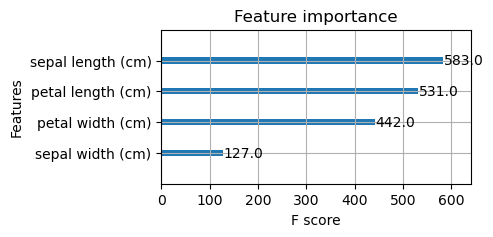

In [37]:
# XGBoost 모델의 feature importance 시각화 (LightGBM 에서도 동일)
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2))
plot_importance(xgb_wrapper, ax=ax)

In [52]:
# 범주형 변수가 있어도 XGBoost 사용가능 (1.5 이상 버전부터)

data = {"feature1": [1, 2, 3, 1, 2, 3, 1],  # 숫자형
    "feature2": ["A", "B", "A", "B", "A", "B", "B"],  # 범주형
    "label": [0, 1, 0, 1, 0, 1, 0]}
df = pd.DataFrame(data)

# 범주형 데이터 지정
df["feature2"] = df["feature2"].astype("category")  # Pandas categorical type 지정

# 데이터 분할
X = df.drop("label", axis=1)
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 (enable_categorical=True 추가)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42,
                              enable_categorical=True)  # ✅ 범주형 데이터 직접 사용

# 모델 학습
xgb_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = xgb_model.predict(X_test)
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")

정확도: 0.5000


#### LGBM (LightGBM)
- XGBoost 보다 속도가 빠르면서도 성능이 밀리지 않는 더 최신모델
- XGBoost 포함 대부분 트리구조는 level wise 의 균형적인 트리 알고리즘을 사용. level wise 는 과적합에 강하지만, 균형을 맞추기 위한 시간이 필요. LightGBM은 leaf wise 방식으로 leaf를 지속 분리해서 같은 시간동안 예측오류를 더 많이 최소화.
- 카테고리형 피처를 원-핫 인코딩 하지 않고도 자동 변환하여 최적분할한다. 


In [68]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05, verbose=-1) # early stopping 기능 추가 

callbacks = [
    early_stopping(stopping_rounds=10)
]

x_tr, x_val, y_tr, y_val = train_test_split(x_train_clf, y_train_clf,
                                                   test_size = 0.2, random_state=11)

evals = [(x_val,y_val)]
lgbm_wrapper.fit(x_tr, y_tr, eval_metric="logloss", eval_set=evals, callbacks=callbacks)
preds = lgbm_wrapper.predict(x_test_clf)
print(f"LightGBM 정확도: {accuracy_score(y_test_clf, preds):.4f}")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.388271
LightGBM 정확도: 0.8667


In [ ]:
# 범주형 변수가 있는 혼합형 데이터셋에서 LGBM 적용. 위에 XGBoost 예시코드와 거의 유사함. 
lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

# `categorical_feature` 매개변수로 범주형 컬럼 지정
lgbm_model.fit(X_train, y_train, categorical_feature=["feature2"])

# 5. 예측 및 평가
y_pred = lgbm_model.predict(X_test)
print(f"LightGBM 정확도: {accuracy_score(y_test, y_pred):.4f}")

LightGBM 정확도: 0.5000


#### CatBoost

In [72]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=0)

cat_features = ["feature2"] 
catboost_model.fit(X_train, y_train, cat_features=cat_features)

y_pred = catboost_model.predict(X_test)
print(f"CatBoost 정확도: {accuracy_score(y_test, y_pred):.4f}")

CatBoost 정확도: 1.0000
